In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn

# !pip install tqdm
# !pip install rougue-score
# !pip install seaborn
# !pip install matplotlib
# !pip install evaluate
# !pip install nltk


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import lmstudio as lms
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from tqdm import tqdm
import time  # optional, for example timing

import evaluate

import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

d:\06_class_notes\2025_spring\deep_learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# setup directories
EVAL_DIR = './eval'
os.makedirs(EVAL_DIR, exist_ok=True)

OUTPUT_DIR = './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# retrieve test set manually labeled for each task
df = pd.read_csv(os.path.join(EVAL_DIR, "test_data.csv"), index_col='Unnamed: 0', encoding='cp1252')

In [4]:
df.head()

,content,sentiment,key_phrase,summary
148,HTML and CSS if very nicely covered but later ...,-1,everything has updated so much that it became ...,This reviewer is satisfied with HTML and CSS t...
49,"Initially, I rated this course 5 stars and EVE...",-1,huge disappointment at the end,The course started off strong but fell off due...
138,Best course ever for web development. No one c...,1,Best course ever for web development.,The reviewer praises the course for its compre...
91,The course is good ! BUT I think when teaching...,0,The course is good !,"The course is overall good, but the reviewer s..."
119,"just a average course, she just ask you to rea...",-1,room for lots of improvement,"The reviewer considers the course average, cit..."


In [5]:
df.shape

(50, 4)

## 1. Prompt Engineering

In [21]:
def sentiment_classification(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "sentiment": { "type": "integer" },
            },
            "required": ["sentiment"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Classify the sentiment of the following customer review as 1 if it is overall positive, 0 if neutral, or -1 if negative.
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f""" 
            Use one of the following labels to classify the sentiment of the following online course review: 1 for positive, 0 for neutral, -1 for negative.
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are a sentiment analysis assistant. 
            Read the following customer review and classify its overall sentiment as 1 for positive , 0 for neutral, or -1 for negative, based on the customer's tone and opinion. 
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'sentiment': response.parsed['sentiment'],
        })

    return res

In [22]:
def phrase_extraction(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "key_phrase": { "type": "string" },
            },
            "required": ["key_phrase"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Extract the most significant phrase of praise or complaint from the following review. 
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f"""
            What is the most significant phrase of praise or complaint from the following review.
            Be concise and keep it within 10-15 words
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are an assistant analyzing customer feedback on online courses. 
            Your task is to extract a key phrase of praises or complaints mentioned in the review. 
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'key_phrase': response.parsed['key_phrase'],
        })

    return res

In [23]:
def review_summarization(reviews, model, prompt_ver=1):
    res = []
    for review in reviews:
        # define response format
        response_schema = {
            "type": "object",
            "properties": {
                "summary": { "type": "string" },
            },
            "required": ["summary"],
        }
        # construct prompt
        if prompt_ver==1:
            prompt = f""" 
            Provide a 1-2 sentence summary of the given review.
            Review: {review}
            """
        elif prompt_ver==2:
            prompt = f"""
            Read the customer review and summarize it in 1-2 sentences that capture the experience and opinion of the customer.
            Review: {review}
            """
        elif prompt_ver==3:
            prompt = f"""
            You are a helpful assistant summarizing customer feedback for an online course. 
            Write a short (1-2 sentence) summary that captures the core experience and opinion of the customer.
            Review: {review}
            """

        response = model.respond(prompt, response_format=response_schema)

        res.append({
            'review': review,
            'summary': response.parsed['summary'],
        })

    return res

## 2. Obtaining prediction / responses

### 2.1. llama-3.2-3b-instruct

In [28]:
# load model
MODEL_NAME = "llama-3.2-3b-instruct"
model = lms.llm(MODEL_NAME)

#### 1.1.1. Task 1: Sentiment classification

In [29]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:47<01:34, 47.13s/it]

Version 1 done in 47.10 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:34<00:47, 47.47s/it]

Version 2 done in 47.70 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [02:19<00:00, 46.66s/it]

Version 3 done in 45.09 seconds


#### 1.1.2. Task 2: Key complaint or praise extraction

In [30]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [01:06<02:12, 66.19s/it]

Version 1 done in 66.16 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [02:18<01:09, 69.94s/it]

Version 2 done in 72.52 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [03:45<00:00, 75.31s/it]

Version 3 done in 87.15 seconds


#### 1.1.3. Task 3: Review summarization

In [31]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [02:19<04:39, 139.91s/it]

Version 1 done in 139.82 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [05:06<02:35, 155.63s/it]

Version 2 done in 166.59 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [08:47<00:00, 175.91s/it]

Version 3 done in 221.10 seconds


In [32]:
# unload the model
model.unload()

### 2.2. gemma-3-4b-it

In [33]:
# load model
MODEL_NAME = "gemma-3-4b-it"
model = lms.llm(MODEL_NAME)

#### 2.2.1. Task 1: Sentiment classification

In [34]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:25<00:51, 25.98s/it]

Version 1 done in 25.98 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [00:52<00:26, 26.50s/it]

Version 2 done in 26.85 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:15<00:00, 25.08s/it]

Version 3 done in 22.39 seconds


#### 2.2.2. Task 2: Key complaint or praise extraction

In [35]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:27<00:55, 27.52s/it]

Version 1 done in 27.52 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:00<00:30, 30.77s/it]

Version 2 done in 33.05 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:32<00:00, 30.87s/it]

Version 3 done in 32.05 seconds


#### 2.2.3. Task 3: Review summarization

In [36]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [01:07<02:14, 67.23s/it]

Version 1 done in 67.22 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [02:12<01:06, 66.17s/it]

Version 2 done in 65.41 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [03:06<00:00, 62.18s/it]

Version 3 done in 53.87 seconds


In [37]:
# unload model
model.unload()

### 2.3. falcon3-3b-instruct

In [38]:
# load model
MODEL_NAME = "falcon3-3b-instruct"
model = lms.llm(MODEL_NAME)

#### 2.2.1. Task 1: Sentiment classification

In [39]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    sentiments = sentiment_classification(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task1_df = pd.DataFrame(sentiments)
    task1_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_1_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:16<00:32, 16.13s/it]

Version 1 done in 16.12 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [00:31<00:15, 15.92s/it]

Version 2 done in 15.77 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [00:46<00:00, 15.65s/it]

Version 3 done in 15.03 seconds


#### 2.2.2. Task 2: Key complaint or praise extraction

In [40]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    phrases = phrase_extraction(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task2_df = pd.DataFrame(phrases)
    task2_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_2_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:26<00:53, 26.94s/it]

Version 1 done in 26.93 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [00:53<00:26, 26.72s/it]

Version 2 done in 26.57 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:16<00:00, 25.41s/it]

Version 3 done in 22.70 seconds


#### 2.2.3. Task 3: Review summarization

In [41]:
for prompt_ver in tqdm(range(1, 4), desc="Processing Prompt Versions"):
    start_time = time.time()  # start timing the iteration

    tqdm.write(f'Prompt version: {prompt_ver}')
    summaries = review_summarization(reviews=df['content'], model=model, prompt_ver=prompt_ver)
    
    task3_df = pd.DataFrame(summaries)
    task3_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_task_3_v{prompt_ver}.csv'), index=False)

    end_time = time.time()
    tqdm.write(f"Version {prompt_ver} done in {end_time - start_time:.2f} seconds")

Processing Prompt Versions:   0%|          | 0/3 [00:00<?, ?it/s]

Prompt version: 1


Processing Prompt Versions:  33%|███▎      | 1/3 [00:41<01:23, 41.51s/it]

Version 1 done in 41.50 seconds
Prompt version: 2


Processing Prompt Versions:  67%|██████▋   | 2/3 [01:19<00:39, 39.70s/it]

Version 2 done in 38.44 seconds
Prompt version: 3


Processing Prompt Versions: 100%|██████████| 3/3 [01:59<00:00, 39.78s/it]

Version 3 done in 39.40 seconds


In [42]:
# unload model
model.unload()

## 3. Evaluation

In [44]:
llama_model = "llama-3.2-3b-instruct"
gemma_model = "gemma-3-4b-it"
falcon_model = "falcon3-3b-instruct"

### 3.1. Task 1: Sentiment classification

#### F1 score

In [45]:
def get_f1_score(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_1_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_1_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_1_v{prompt_ver}.csv"))
    
    # calculate f1 score & accuracy score
    llama_f1 = f1_score(df['sentiment'], llama_['sentiment'], average='micro')
    gemma_f1 = f1_score(df['sentiment'], gemma_['sentiment'], average='micro')
    falcon_f1 = f1_score(df['sentiment'], falcon_['sentiment'], average='micro')

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f'{llama_model}: {llama_f1:.2f}')
    print(f'{gemma_model}: {gemma_f1:.2f}')
    print(f'{falcon_model}: {falcon_f1:.2f}')
    print()

In [46]:
for i in range(1, 4):
    get_f1_score(i)

Prompt version 1:
llama-3.2-3b-instruct: 0.80
gemma-3-4b-it: 0.84
falcon3-3b-instruct: 0.86

Prompt version 2:
llama-3.2-3b-instruct: 0.82
gemma-3-4b-it: 0.80
falcon3-3b-instruct: 0.86

Prompt version 3:
llama-3.2-3b-instruct: 0.76
gemma-3-4b-it: 0.86
falcon3-3b-instruct: 0.88



#### Confusion matrix

In [47]:
def get_confusion_matrix(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_1_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_1_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_1_v{prompt_ver}.csv"))

    # calculate confusion matrix
    llama_cm = confusion_matrix(df['sentiment'], llama_['sentiment'], labels=[-1, 0, 1])
    gemma_cm = confusion_matrix(df['sentiment'], gemma_['sentiment'], labels=[-1, 0, 1])
    falcon_cm = confusion_matrix(df['sentiment'], falcon_['sentiment'], labels=[-1, 0, 1])

    # Plot result
    # Plot side by side
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    sns.heatmap(llama_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[0].set_title(f'Llama - prompt version {prompt_ver}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(gemma_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[1].set_title(f'Gemma - prompt version {prompt_ver}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    sns.heatmap(falcon_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], xticklabels=[-1,0,1], yticklabels=[-1,0,1],)
    axes[2].set_title(f'Falcon - prompt version {prompt_ver}')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')

    plt.tight_layout()
    plt.show()

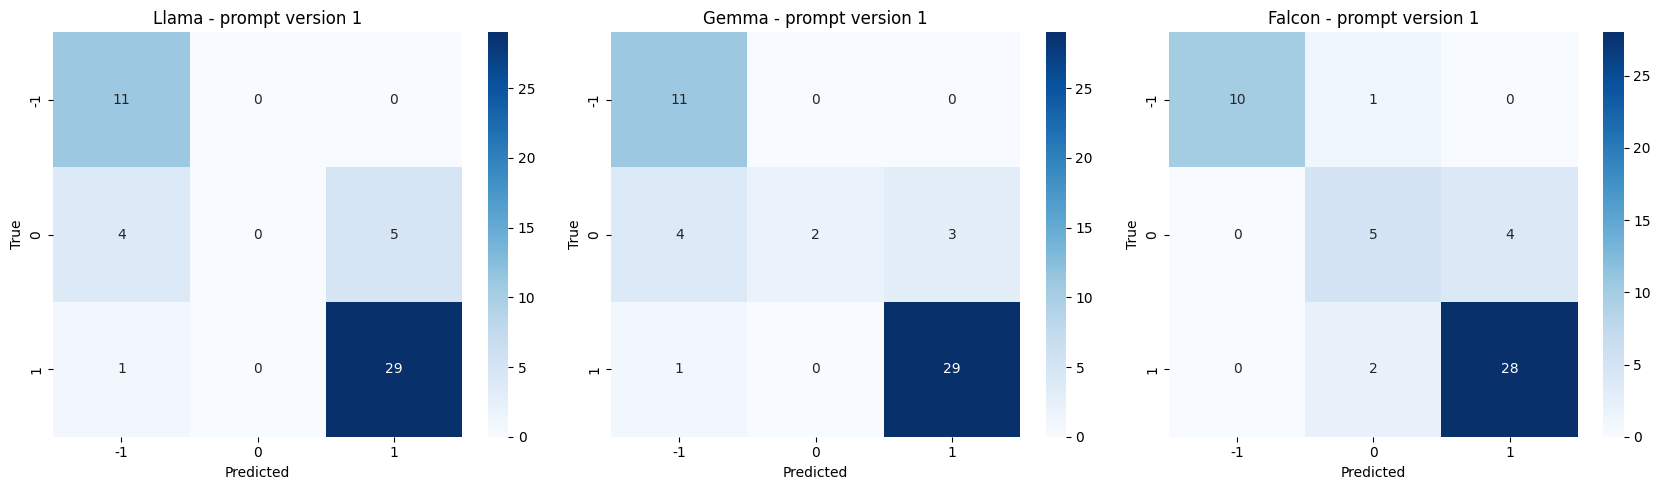

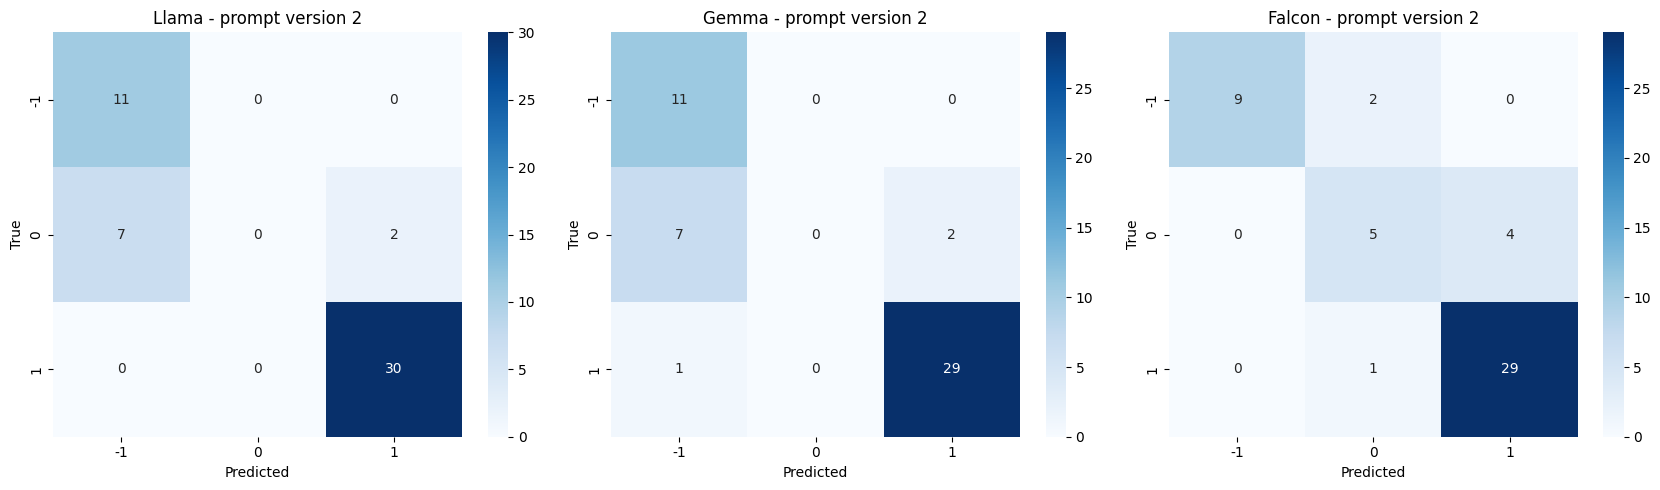

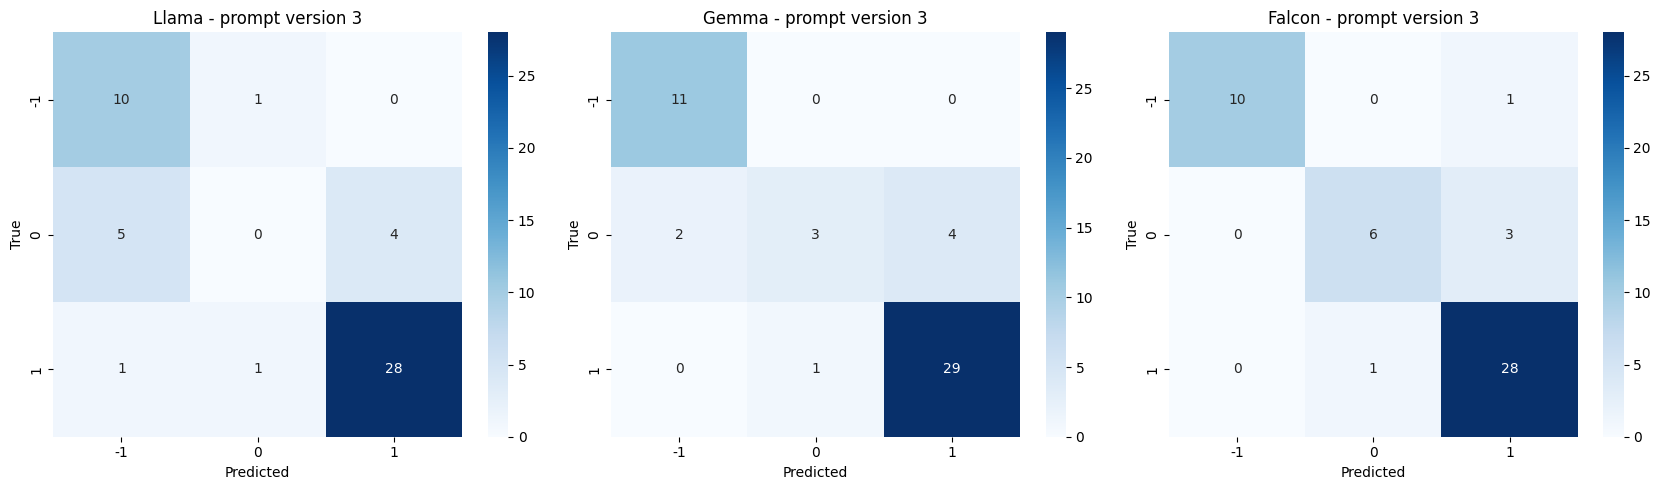

In [48]:
for i in range(1, 4):
    get_confusion_matrix(i)

### 3.2. Task 2: Phrase extraction

#### Token-level Precision / Recall / F1

In [49]:
# from sklearn.metrics import precision_score, recall_score, f1_score

def token_level_scores(pred, gold):
    pred_tokens = pred.split()
    gold_tokens = gold.split()
    pred_set = set(pred_tokens)
    gold_set = set(gold_tokens)
    
    true_positives = len(pred_set & gold_set)
    precision = true_positives / len(pred_set) if pred_set else 0
    recall = true_positives / len(gold_set) if gold_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    
    return precision, recall, f1


def get_token_level_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_2_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_2_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_2_v{prompt_ver}.csv"))

    # calculate average token level precision, recall, f1
    llama_precision = []
    llama_recall = []
    llama_f1 = []

    gemma_precision = []
    gemma_recall = []
    gemma_f1 = []

    falcon_precision = []
    falcon_recall = []
    falcon_f1 = []


    for gold_, llama_pred_, gemma_pred_, falcon_pred_ in zip(df['key_phrase'], llama_['key_phrase'], gemma_['key_phrase'], falcon_['key_phrase']):
        llama_scores = token_level_scores(llama_pred_, gold_)
        gemma_scores = token_level_scores(gemma_pred_, gold_)
        falcon_scores = token_level_scores(falcon_pred_, gold_)

        llama_precision.append(llama_scores[0])
        llama_recall.append(llama_scores[1])
        llama_f1.append(llama_scores[2])

        gemma_precision.append(gemma_scores[0])
        gemma_recall.append(gemma_scores[1])
        gemma_f1.append(gemma_scores[2])

        falcon_precision.append(falcon_scores[0])
        falcon_recall.append(falcon_scores[1])
        falcon_f1.append(falcon_scores[2])

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f'{llama_model}: Precision: {np.mean(llama_precision):.4f}, Recall: {np.mean(llama_recall):.4f}, F1: {np.mean(llama_f1):.4f}')
    print(f'{gemma_model}: Precision: {np.mean(gemma_precision):.4f}, Recall: {np.mean(gemma_recall):.4f}, F1: {np.mean(gemma_f1):.4f}')
    print(f'{falcon_model}: Precision: {np.mean(falcon_precision):.4f}, Recall: {np.mean(falcon_recall):.4f}, F1: {np.mean(falcon_f1):.4f}')
    print()

In [50]:
for i in range(1, 4):
    get_token_level_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: Precision: 0.3723, Recall: 0.3766, F1: 0.3309
gemma-3-4b-it: Precision: 0.5203, Recall: 0.4034, F1: 0.4115
falcon3-3b-instruct: Precision: 0.3117, Recall: 0.4194, F1: 0.3298

Prompt version 2:
llama-3.2-3b-instruct: Precision: 0.2191, Recall: 0.2837, F1: 0.2238
gemma-3-4b-it: Precision: 0.2819, Recall: 0.2926, F1: 0.2594
falcon3-3b-instruct: Precision: 0.3374, Recall: 0.3673, F1: 0.3055

Prompt version 3:
llama-3.2-3b-instruct: Precision: 0.3253, Recall: 0.2794, F1: 0.2839
gemma-3-4b-it: Precision: 0.3208, Recall: 0.3112, F1: 0.2904
falcon3-3b-instruct: Precision: 0.4099, Recall: 0.4512, F1: 0.3807



### 3.3. Task 3: Summarization

#### ROUGE-L and ROUGE-1 

In [51]:
scorer = evaluate.load('rouge')

In [52]:
def get_rouge_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_3_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_3_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_3_v{prompt_ver}.csv"))

    # ROUGE-L and ROUGE-1 scores
    llama_rouge = scorer.compute(predictions=llama_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)
    gemma_rouge = scorer.compute(predictions=gemma_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)
    falcon_rouge = scorer.compute(predictions=falcon_['summary'].tolist(), references=df['summary'].tolist(), use_stemmer=True)

    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f"{llama_model}: ROUGE-1: {llama_rouge['rouge1']:.4f}, ROUGE-L: {llama_rouge['rougeL']:.4f}")
    print(f"{gemma_model}: ROUGE-1: {gemma_rouge['rouge1']:.4f}, ROUGE-L: {gemma_rouge['rougeL']:.4f}")
    print(f"{falcon_model}: ROUGE-1: {falcon_rouge['rouge1']:.4f}, ROUGE-L: {falcon_rouge['rougeL']:.4f}")
    print()

In [53]:
for i in range(1, 4):
    get_rouge_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: ROUGE-1: 0.4260, ROUGE-L: 0.3298
gemma-3-4b-it: ROUGE-1: 0.4407, ROUGE-L: 0.3279
falcon3-3b-instruct: ROUGE-1: 0.3814, ROUGE-L: 0.2817

Prompt version 2:
llama-3.2-3b-instruct: ROUGE-1: 0.4154, ROUGE-L: 0.2981
gemma-3-4b-it: ROUGE-1: 0.4201, ROUGE-L: 0.3096
falcon3-3b-instruct: ROUGE-1: 0.3890, ROUGE-L: 0.2983

Prompt version 3:
llama-3.2-3b-instruct: ROUGE-1: 0.4070, ROUGE-L: 0.2947
gemma-3-4b-it: ROUGE-1: 0.3785, ROUGE-L: 0.2921
falcon3-3b-instruct: ROUGE-1: 0.3574, ROUGE-L: 0.2551



####  METEOR

In [54]:
def get_meteor_scores(prompt_ver):
    # retrieve model's responses
    llama_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{llama_model}_task_3_v{prompt_ver}.csv"))
    gemma_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{gemma_model}_task_3_v{prompt_ver}.csv"))
    falcon_ = pd.read_csv(os.path.join(OUTPUT_DIR, f"{falcon_model}_task_3_v{prompt_ver}.csv"))

    # calculate meteor score for each summary
    llama_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(llama_summary)) for gold, llama_summary in zip(df['summary'], llama_['summary'])]
    gemma_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(gemma_summary)) for gold, gemma_summary in zip(df['summary'], gemma_['summary'])]
    falcon_meteor = [meteor_score([word_tokenize(gold)], word_tokenize(falcon_summary)) for gold, falcon_summary in zip(df['summary'], falcon_['summary'])]
    # print result
    print(f'Prompt version {prompt_ver}:')
    print(f"{llama_model}: {np.mean(llama_meteor):.4f}")
    print(f"{gemma_model}: {np.mean(gemma_meteor):.4f}")
    print(f"{falcon_model}: {np.mean(falcon_meteor):.4f}")
    print()

In [55]:
for i in range(1, 4):
    get_meteor_scores(i)

Prompt version 1:
llama-3.2-3b-instruct: 0.3347
gemma-3-4b-it: 0.3624
falcon3-3b-instruct: 0.2859

Prompt version 2:
llama-3.2-3b-instruct: 0.3515
gemma-3-4b-it: 0.3284
falcon3-3b-instruct: 0.2736

Prompt version 3:
llama-3.2-3b-instruct: 0.3495
gemma-3-4b-it: 0.2701
falcon3-3b-instruct: 0.2533

